## Defense study - 2
This jupyter notebook creates plots to study the impact of upgrading/new stations near max waiting. 

*Plug count in (1:10)*

### 0. Analysis IDs to compare

In [1]:
# Define the set id for the analysis_ids that we want to compare
set_id  = (125, 126, 127, 128 )

### 1. Package Installs

In [2]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [3]:
# Seaborn for plotting
#!pip install seaborn

In [4]:
#!pip install xarray

In [5]:
# Plotly for plotting 
#!pip install plotly

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
import xarray as xr
import plotly.data as pdata
from barchart3d import barchart3d
import math

### 2. Environment Variables

In [7]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [8]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'chargeval_dev'

### 3. Database connection

In [9]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [10]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 13.2 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [11]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [12]:
cur.execute('select count(veh_id) from wa_bevs')
evs_in_wa = cur.fetchone()
evs_in_wa

(46727,)

In [13]:
sql_evs_in_sim = 'select count(veh_id), analysis_id from evtrip_scenarios where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_in_sim, (analysis_ids,))
evs_in_sim = pd.read_sql_query(sql=sql_evs_in_sim, con=conn, params=(set_id,))
evs_in_sim

,count,analysis_id
0,861,671
1,899,672
2,870,673
3,884,674
4,872,675
...,...,...
150,882,821
151,930,822
152,886,823
153,904,824


In [14]:
sql_evs_fin = 'select count(veh_id), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_fin, (analysis_ids,))
evs_fin = pd.read_sql_query(sql=sql_evs_fin, con=conn, params=(set_id,))
evs_fin

,count,analysis_id
0,853,671
1,893,672
2,865,673
3,881,674
4,867,675
...,...,...
150,873,821
151,923,822
152,881,823
153,900,824


In [15]:
sql_evs_str = 'select count(veh_id), analysis_id from ev_stranded where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_str, (analysis_ids,)) # Uncomment for debugging the query
evs_str = pd.read_sql_query(sql=sql_evs_str, con=conn, params=(set_id,))
evs_str

,count,analysis_id
0,5,753
1,9,781
2,5,758
3,7,770
4,4,764
...,...,...
150,3,704
151,5,760
152,8,671
153,7,742


In [16]:
sql_evs_str_loc = '''select stranded_lat, stranded_lng, est.analysis_id, coalesce(ne.count, 0) as nevse_count
from ev_stranded est
         left join (
    select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on est.analysis_id = ne.analysis_id
where est.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
ORDER BY nevse_count;'''
evs_str_loc = pd.read_sql_query(sql=sql_evs_str_loc, con=conn, params=(set_id,))
evs_str_loc.head()

,stranded_lat,stranded_lng,analysis_id,nevse_count
0,47.289542,-124.236750,674,0
1,48.010082,-122.107553,674,0
2,47.911286,-122.056103,671,0
3,48.235758,-122.063082,671,0
4,47.113044,-124.173881,671,0


In [17]:
sql_evmt = 'select sum(distance_travelled), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evmt, (analysis_ids,))
evmt = pd.read_sql_query(sql=sql_evmt, con=conn, params=(set_id,))
evmt

,sum,analysis_id
0,100926.0,671
1,106000.0,672
2,96711.0,673
3,101722.0,674
4,100275.0,675
...,...,...
150,104270.0,821
151,111757.0,822
152,99359.0,823
153,105338.0,824


In [18]:
sql_cs = 'select count(cs_id), analysis_id from evse_charging_session where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_cs, (analysis_ids,))
cs = pd.read_sql_query(sql=sql_cs, con=conn, params=(set_id,))
cs

,count,analysis_id
0,564,671
1,569,672
2,540,673
3,577,674
4,537,675
...,...,...
150,598,821
151,653,822
152,601,823
153,624,824


In [19]:
sql_ws = 'select count(wait_id), analysis_id from evse_evs_waiting where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_ws, (analysis_ids,))
ws = pd.read_sql_query(sql=sql_ws, con=conn, params=(set_id,))
ws

,count,analysis_id
0,63,753
1,93,781
2,62,758
3,78,770
4,79,764
...,...,...
150,27,704
151,80,760
152,105,671
153,83,742


In [20]:
# basecase_aid = 438
# sql_evse_util = """SELECT epd.analysis_id,
#       epd.simulation_ts::timestamp as datetime,
#       sum(epd.power_val)           as total_power,
#       coalesce(ne.count, 0)               as nevse_count
#FROM evse_power_draw epd
#         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
#              on epd.analysis_id = ne.analysis_id
#WHERE epd.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
#GROUP BY epd.simulation_ts, epd.analysis_id, nevse_count
#ORDER BY nevse_count, epd.simulation_ts::timestamp;"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
#evse_util = pd.read_sql_query(sql=sql_evse_util, con=conn, params=(set_id,))
#evse_util

In [21]:
sql_seeds = """select param_value as seed, analysis_id from analysis_params where analysis_id IN (select analysis_id from analysis_record where set_id = 125 order by analysis_id) and param_id = 1;"""
seeds = pd.read_sql_query(sql=sql_seeds, con=conn)['seed'].tolist()
# a_ids = a_ids[:-1]
seeds

['31', '386', '259', '420', '369']

In [22]:
sql_aids = """select analysis_id from analysis_record where set_id IN %s order by analysis_id"""
a_ids = pd.read_sql_query(sql=sql_aids, con=conn, params=(set_id,))['analysis_id'].tolist()
# a_ids = a_ids[:-1]
#a_ids

In [23]:
basecase_aid = 484
sql_count_stats = """select count(ets.veh_id) as sim_count,
       ets.analysis_id,
       coalesce(ne.count, 0) as nevse_count,
       ef.fin_count,
       ef.evmt,
       es.str_count,
       ecs.cs_count,
       ew.wait_count
from evtrip_scenarios ets
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on ets.analysis_id = ne.analysis_id
         join (select count(veh_id) as fin_count, sum(distance_travelled) as evmt, analysis_id
               from ev_finished
               group by analysis_id) as ef
              on ets.analysis_id = ef.analysis_id
         join (select count(veh_id) as str_count, analysis_id from ev_stranded group by analysis_id) as es
              on ets.analysis_id = es.analysis_id
         join (select count(cs_id) as cs_count, analysis_id from evse_charging_session group by analysis_id) as ecs
              on ets.analysis_id = ecs.analysis_id
join (select count(wait_id) as wait_count, analysis_id from evse_evs_waiting group by analysis_id) as ew
              on ets.analysis_id = ew.analysis_id
where ets.analysis_id IN (select analysis_id from analysis_record where set_id IN %s UNION (select %s as analysis_id))
group by ets.analysis_id, nevse_count, ef.fin_count, es.str_count, ef.evmt, ecs.cs_count, ew.wait_count
order by ets.analysis_id desc
;"""
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=(set_id,basecase_aid))
#count_stats.sort_values(by=['analysis_id'], inplace=True)
count_stats

,sim_count,analysis_id,nevse_count,fin_count,evmt,str_count,cs_count,wait_count
0,899,825,5,892,104796.0,7,612,101
1,904,824,5,900,105338.0,4,624,71
2,886,823,5,881,99359.0,5,601,43
3,930,822,5,923,111757.0,7,653,80
4,882,821,5,873,104270.0,9,598,63
...,...,...,...,...,...,...,...,...
151,884,674,0,881,101722.0,3,577,126
152,870,673,0,865,96711.0,5,540,78
153,899,672,0,893,106000.0,6,569,109
154,861,671,0,853,100926.0,8,564,105


In [24]:
# count_stats.dtypes
# count_stats = count_stats.sort_values(by=['nevse_count'])
# count_stats

In [25]:
sql_comp_stats = """select lai.action_tstamp_tx                                               as start_time,
       lau.aid,
       lau.action_tstamp_tx                                               as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
       coalesce(ne.count, 0) as nevse_count,
       ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
         DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
        DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx)) as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on (lai.row_data -> 'analysis_id')::int = ne.analysis_id
where lai.action = 'I'
  and lai.row_data -> 'analysis_id' ~* (select string_agg(cast(analysis_id as text), '|') from analysis_record where set_id IN %s)
ORDER BY nevse_count
;"""
# data = '|'.join(map(str,set_id))
comp_stats = pd.read_sql_query(sql=sql_comp_stats, con=conn, params=(set_id,))
comp_stats

,start_time,aid,end_time_tripgen,action_tstamp_tx,ev_count,nevse_count,time_taken_tripgen,time_taken_eviabm
0,2021-04-29 05:22:45.237232+00:00,671,2021-04-29 06:25:05.999102+00:00,2021-04-29 12:03:41.330214+00:00,# EV: 861,0,62.0,338.0
1,2021-04-29 05:22:48.438746+00:00,672,2021-04-29 06:26:32.783106+00:00,2021-04-29 12:34:34.266176+00:00,# EV: 899,0,63.0,368.0
2,2021-04-29 05:22:51.590769+00:00,673,2021-04-29 06:22:42.291101+00:00,2021-04-29 10:52:30.632950+00:00,# EV: 870,0,59.0,269.0
3,2021-04-29 05:22:54.742823+00:00,674,2021-04-29 06:18:45.903093+00:00,2021-04-29 11:04:21.068560+00:00,# EV: 884,0,55.0,285.0
4,2021-04-29 05:22:57.904371+00:00,675,2021-04-29 06:19:07.371218+00:00,2021-04-29 10:52:57.132768+00:00,# EV: 872,0,56.0,273.0
...,...,...,...,...,...,...,...,...
150,2021-05-01 00:21:54.081968+00:00,821,2021-05-01 01:52:27.503291+00:00,2021-05-01 05:13:56.924820+00:00,# EV: 882,5,90.0,201.0
151,2021-05-01 00:21:57.253924+00:00,822,2021-05-01 01:53:43.227097+00:00,2021-05-01 06:06:56.593193+00:00,# EV: 930,5,91.0,253.0
152,2021-05-01 00:22:00.427099+00:00,823,2021-05-01 01:50:30.707099+00:00,2021-05-01 05:15:24.819811+00:00,# EV: 886,5,88.0,204.0
153,2021-05-01 00:22:03.602666+00:00,824,2021-05-01 01:52:02.258439+00:00,2021-05-01 05:25:08.133204+00:00,# EV: 904,5,89.0,213.0


## Find charging stations with max waiting sessions

In [26]:
basecase_aid = 484
sql_be_ws = """select count(wait_id) as count, analysis_id, evse_id, be.latitude, be.longitude
from evse_evs_waiting ews
         left join built_evse be on
    'b' || cast(be.bevse_id as text) = ews.evse_id
where ews.analysis_id = 484
group by ews.analysis_id, ews.evse_id, be.latitude, be.longitude
order by count desc
limit 5;
"""
be_ws = pd.read_sql_query(sql=sql_be_ws, con=conn, params=(basecase_aid,))
be_ws.head()

,count,analysis_id,evse_id,latitude,longitude
0,27,484,b73433,47.420940,-121.411300
1,26,484,b167497,47.188833,-120.903139
2,13,484,b105362,47.467463,-120.336918
3,9,484,b99297,46.994236,-120.549197
4,7,484,b143835,46.679874,-122.977158


In [57]:
sql_ne_ws = """select ne.latitude, ne.longitude, ne.analysis_id
 from new_evses ne
where analysis_id IN ((select analysis_id from analysis_record where set_id = 106 limit 1)
                       UNION
                      (select analysis_id
                       from analysis_record
                       where set_id = 108
                       limit 1));"""
ne_ws = pd.read_sql_query(sql=sql_ne_ws, con=conn)
ne_ws

,latitude,longitude,analysis_id
0,47.429,-121.61,520
1,47.199,-120.96,520
2,47.539,-120.52,520
3,47.083,-120.74,520
4,46.706,-122.97,520
5,47.258,-121.21,526
6,47.076,-120.71,526
7,47.472,-120.32,526
8,46.947,-119.97,526
9,46.584,-122.89,526


### 5. Plotting

#### 5.1 Vehicle Counts

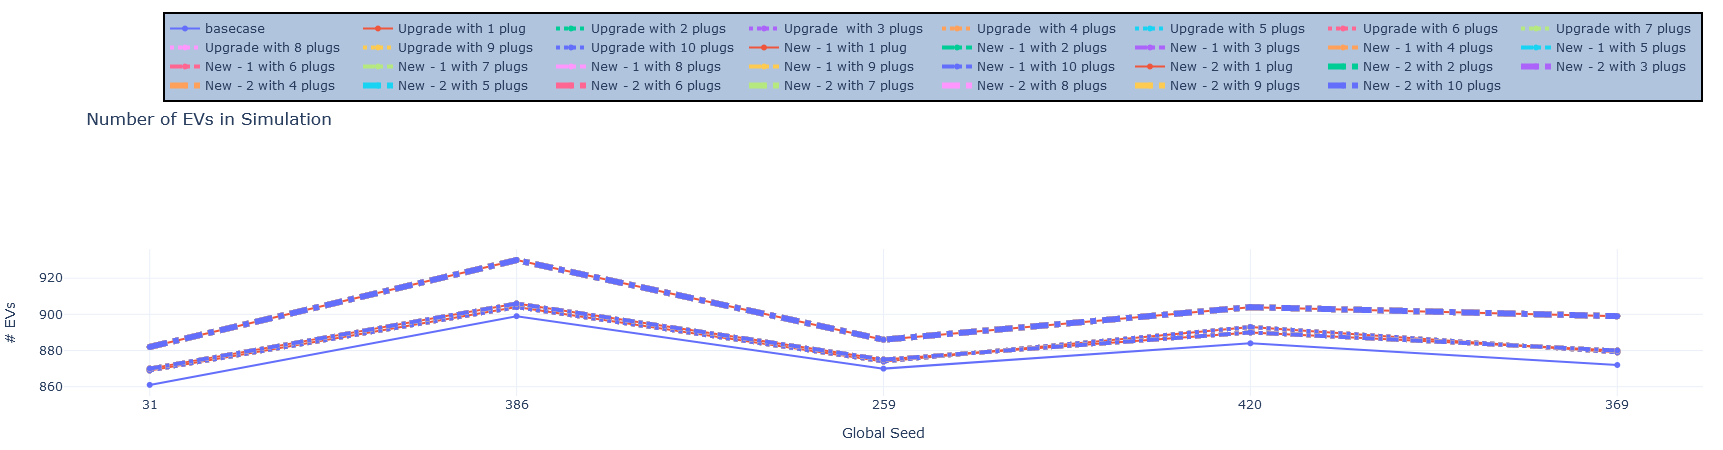

In [46]:
# EVs in simulation
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(671 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 675)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(676 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 680)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(681 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 685)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade with 2 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(686 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 690)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade  with 3 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(691 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 695)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade  with 4 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(696 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 700)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade with 5 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(701 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 705)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade with 6 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(706 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 710)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade with 7 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(711 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 715)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade with 8 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(716 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 720)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade with 9 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(721 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 725)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade with 10 plugs', line=dict(width=4, dash='dot')))

## New - 1
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(726 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 730)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 1 with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(731 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 735)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 1 with 2 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(736 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 740)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 1 with 3 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(741 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 745)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 1 with 4 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(746 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 750)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 1 with 5 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(751 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 755)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 1 with 6 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(756 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 760)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 1 with 7 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(761 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 765)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 1 with 8 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(766 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 770)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 1 with 9 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(771 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 775)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 1 with 10 plugs', line=dict(width=4, dash='dashdot')))

## New - 2
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(776 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 780)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 2 with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(781 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 785)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 2 with 2 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(786 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 790)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 2 with 3 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(791 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 795)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 2 with 4 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(796 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 800)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 2 with 5 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(801 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 805)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 2 with 6 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(806 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 810)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 2 with 7 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(811 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 815)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 2 with 8 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(816 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 820)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 2 with 9 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(821 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 825)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New - 2 with 10 plugs', line=dict(width=6, dash='dashdot')))

fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of EVs in Simulation',
        showlegend = True, yaxis_title="# EVs", 
                  xaxis_title="Global Seed", legend=dict(
    orientation="h",
    yanchor="bottom",
    y=2,
    xanchor="right",
    x=1,
    bgcolor="LightSteelBlue",
    bordercolor="Black",
    borderwidth=2
))
fig.show()

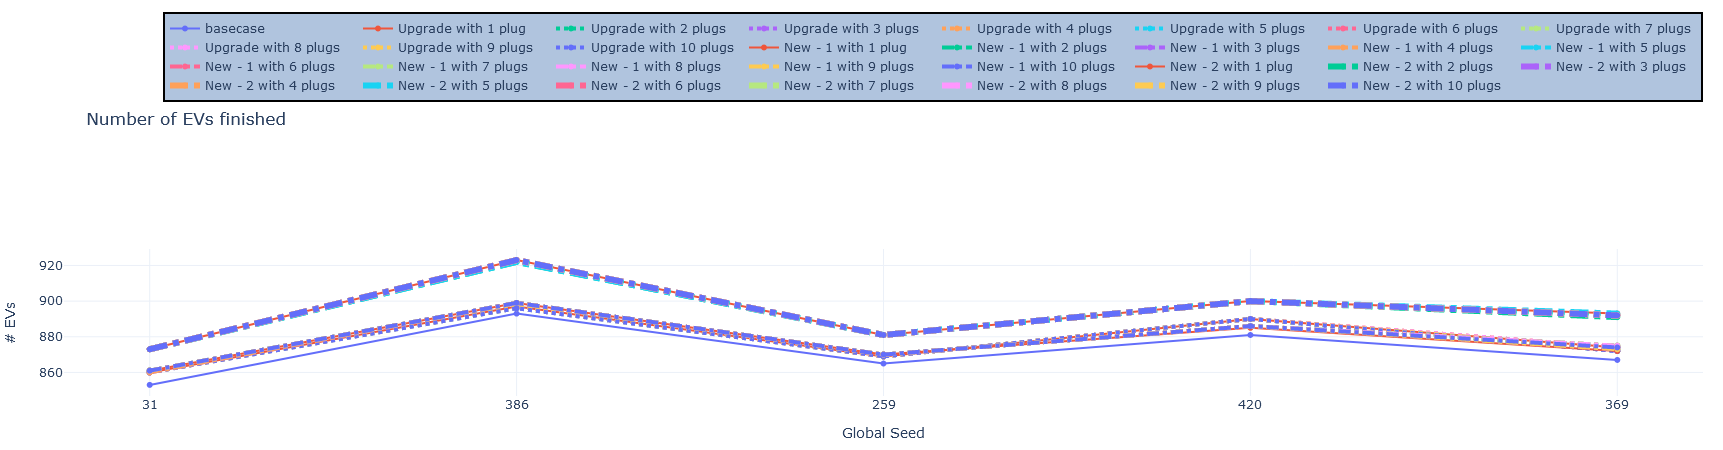

In [48]:
# EVs finished
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(671 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 675)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(676 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 680)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(681 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 685)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade with 2 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(686 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 690)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade with 3 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(691 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 695)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade with 4 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(696 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 700)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade with 5 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(701 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 705)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade with 6 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(706 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 710)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade with 7 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(711 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 715)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade with 8 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(716 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 720)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade with 9 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(721 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 725)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade with 10 plugs', line=dict(width=4, dash='dot')))

## New - 1
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(726 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 730)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 1 with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(731 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 735)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 1 with 2 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(736 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 740)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 1 with 3 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(741 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 745)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 1 with 4 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(746 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 750)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 1 with 5 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(751 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 755)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 1 with 6 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(756 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 760)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 1 with 7 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(761 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 765)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 1 with 8 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(766 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 770)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 1 with 9 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(771 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 775)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 1 with 10 plugs', line=dict(width=4, dash='dashdot')))

## New - 2
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(776 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 780)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 2 with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(781 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 785)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 2 with 2 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(786 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 790)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 2 with 3 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(791 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 795)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 2 with 4 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(796 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 800)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 2 with 5 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(801 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 805)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 2 with 6 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(806 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 810)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 2 with 7 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(811 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 815)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 2 with 8 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(816 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 820)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 2 with 9 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(821 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 825)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New - 2 with 10 plugs', line=dict(width=6, dash='dashdot')))


fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of EVs finished',
        showlegend = True, yaxis_title="# EVs", 
                  xaxis_title="Global Seed", legend=dict(
    orientation="h",
    yanchor="bottom",
    y=2,
    xanchor="right",
    x=1,
    bgcolor="LightSteelBlue",
    bordercolor="Black",
    borderwidth=2
))
fig.show()

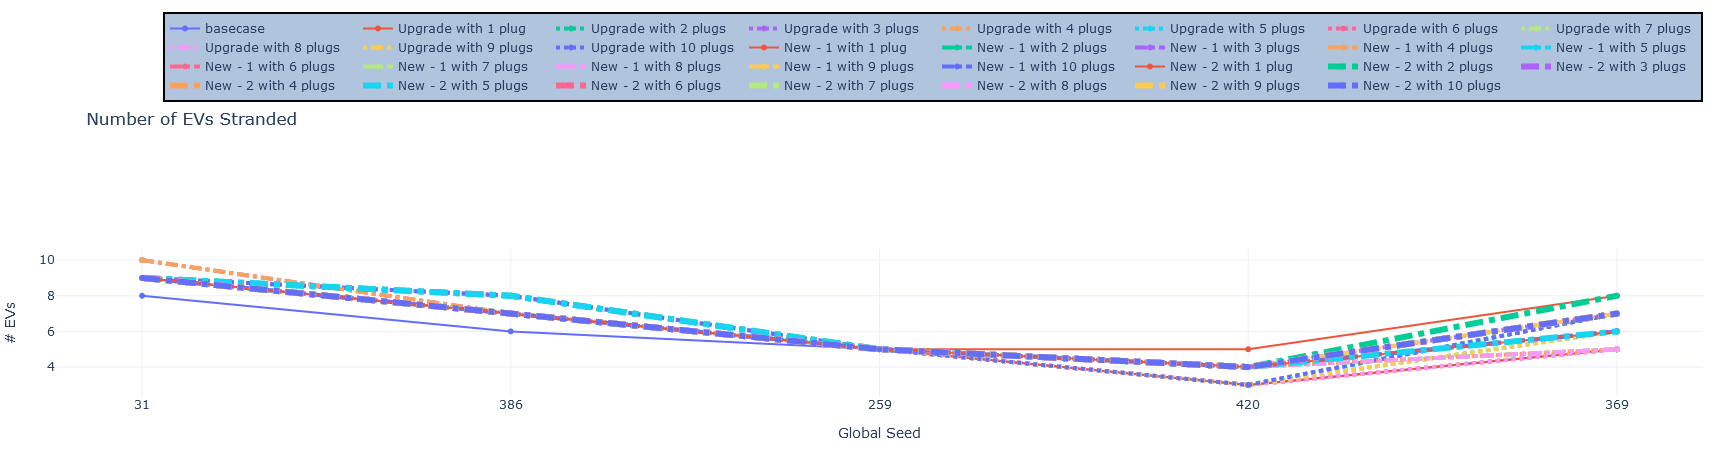

In [50]:
# EVs stranded
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(671 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 675)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(676 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 680)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(681 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 685)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade with 2 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(686 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 690)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade with 3 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(691 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 695)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade with 4 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(696 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 700)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade with 5 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(701 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 705)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade with 6 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(706 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 710)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade with 7 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(711 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 715)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade with 8 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(716 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 720)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade with 9 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(721 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 725)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade with 10 plugs', line=dict(width=4, dash='dot')))

## New - 1
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(726 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 730)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 1 with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(731 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 735)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 1 with 2 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(736 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 740)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 1 with 3 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(741 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 745)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 1 with 4 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(746 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 750)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 1 with 5 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(751 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 755)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 1 with 6 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(756 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 760)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 1 with 7 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(761 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 765)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 1 with 8 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(766 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 770)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 1 with 9 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(771 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 775)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 1 with 10 plugs', line=dict(width=4, dash='dashdot')))

## New - 2
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(776 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 780)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 2 with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(781 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 785)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 2 with 2 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(786 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 790)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 2 with 3 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(791 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 795)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 2 with 4 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(796 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 800)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 2 with 5 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(801 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 805)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 2 with 6 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(806 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 810)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 2 with 7 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(811 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 815)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 2 with 8 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(816 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 820)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 2 with 9 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(821 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 825)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New - 2 with 10 plugs', line=dict(width=6, dash='dashdot')))

fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of EVs Stranded',
        showlegend = True, yaxis_title="# EVs", 
                  xaxis_title="Global Seed", legend=dict(
    orientation="h",
    yanchor="bottom",
    y=2,
    xanchor="right",
    x=1,
    bgcolor="LightSteelBlue",
    bordercolor="Black",
    borderwidth=2
) )
fig.show()

## 5.2 eVMT

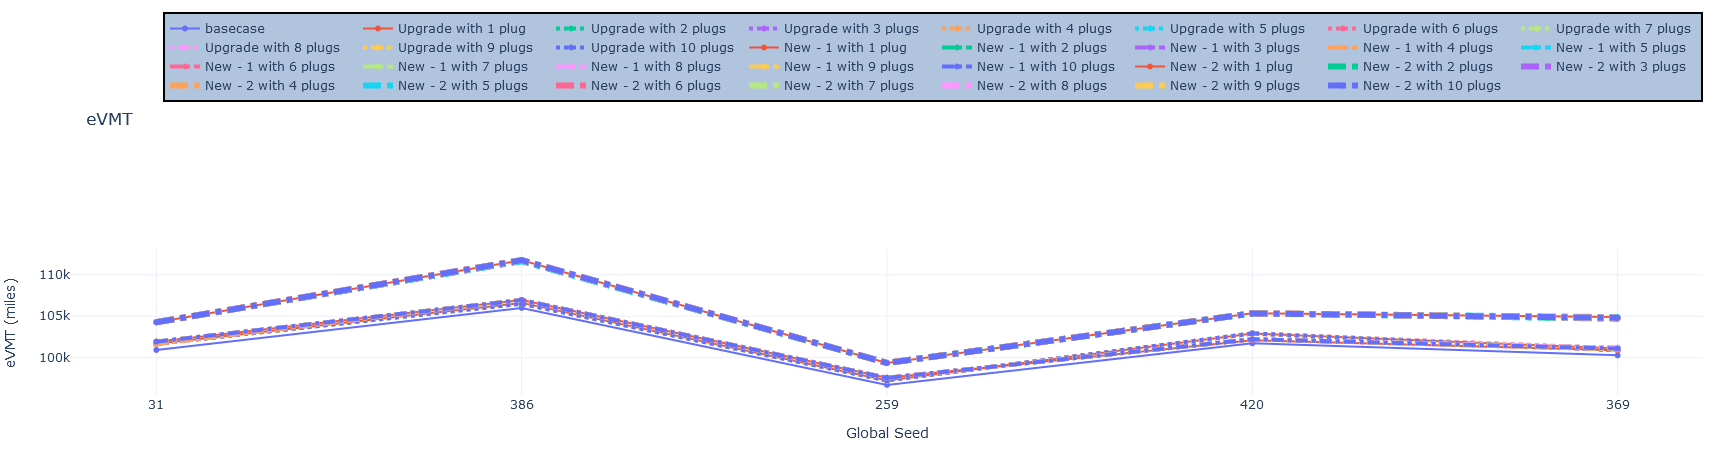

In [51]:
# evmt
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(671 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 675)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(676 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 680)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(681 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 685)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade with 2 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(686 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 690)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade with 3 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(691 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 695)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade with 4 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(696 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 700)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade with 5 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(701 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 705)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade with 6 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(706 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 710)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade with 7 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(711 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 715)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade with 8 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(716 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 720)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade with 9 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(721 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 725)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade with 10 plugs', line=dict(width=4, dash='dot')))

## New - 1
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(726 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 730)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 1 with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(731 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 735)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 1 with 2 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(736 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 740)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 1 with 3 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(741 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 745)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 1 with 4 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(746 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 750)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 1 with 5 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(751 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 755)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 1 with 6 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(756 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 760)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 1 with 7 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(761 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 765)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 1 with 8 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(766 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 770)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 1 with 9 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(771 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 775)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 1 with 10 plugs', line=dict(width=4, dash='dashdot')))

## New - 2
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(776 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 780)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 2 with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(781 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 785)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 2 with 2 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(786 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 790)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 2 with 3 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(791 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 795)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 2 with 4 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(796 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 800)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 2 with 5 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(801 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 805)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 2 with 6 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(806 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 810)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 2 with 7 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(811 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 815)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 2 with 8 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(816 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 820)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 2 with 9 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(821 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 825)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New - 2 with 10 plugs', line=dict(width=6, dash='dashdot')))


fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'eVMT',
        showlegend = True, yaxis_title="eVMT (miles)", 
                  xaxis_title="Global Seed", legend=dict(
    orientation="h",
    yanchor="bottom",
    y=2,
    xanchor="right",
    x=1,
    bgcolor="LightSteelBlue",
    bordercolor="Black",
    borderwidth=2
))
fig.show()

#### 5.3 Charging and Waiting Sessions

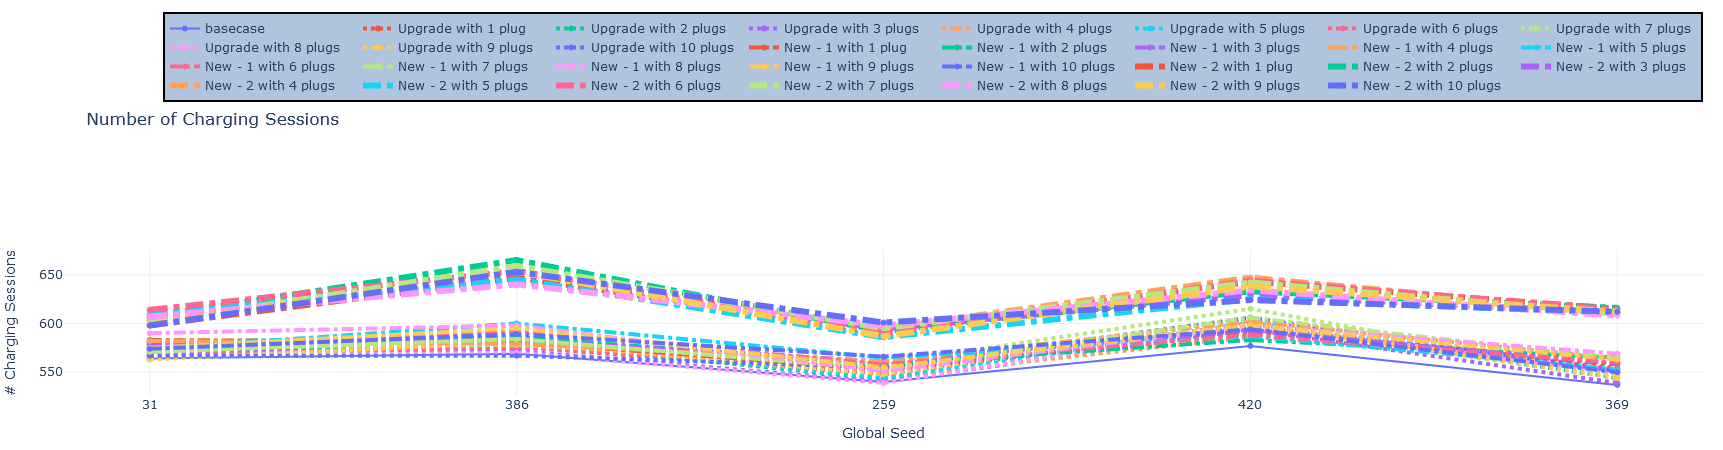

In [59]:
# charging_sessions count
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(671 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 675)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(676 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 680)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade with 1 plug', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(681 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 685)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade with 2 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(686 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 690)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade with 3 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(691 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 695)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade with 4 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(696 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 700)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade with 5 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(701 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 705)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade with 6 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(706 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 710)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade with 7 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(711 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 715)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade with 8 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(716 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 720)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade with 9 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(721 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 725)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade with 10 plugs', line=dict(width=4, dash='dot')))

## New - 1
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(726 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 730)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 1 with 1 plug', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(731 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 735)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 1 with 2 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(736 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 740)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 1 with 3 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(741 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 745)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 1 with 4 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(746 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 750)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 1 with 5 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(751 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 755)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 1 with 6 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(756 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 760)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 1 with 7 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(761 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 765)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 1 with 8 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(766 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 770)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 1 with 9 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(771 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 775)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 1 with 10 plugs', line=dict(width=4, dash='dashdot')))

## New - 2
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(776 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 780)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 2 with 1 plug', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(781 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 785)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 2 with 2 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(786 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 790)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 2 with 3 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(791 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 795)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 2 with 4 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(796 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 800)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 2 with 5 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(801 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 805)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 2 with 6 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(806 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 810)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 2 with 7 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(811 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 815)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 2 with 8 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(816 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 820)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 2 with 9 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(821 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 825)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New - 2 with 10 plugs', line=dict(width=6, dash='dashdot')))


fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of Charging Sessions',
        showlegend = True, yaxis_title="# Charging Sessions", 
                  xaxis_title="Global Seed", legend=dict(
    orientation="h",
    yanchor="bottom",
    y=2,
    xanchor="right",
    x=1,
    bgcolor="LightSteelBlue",
    bordercolor="Black",
    borderwidth=2
))
fig.show()

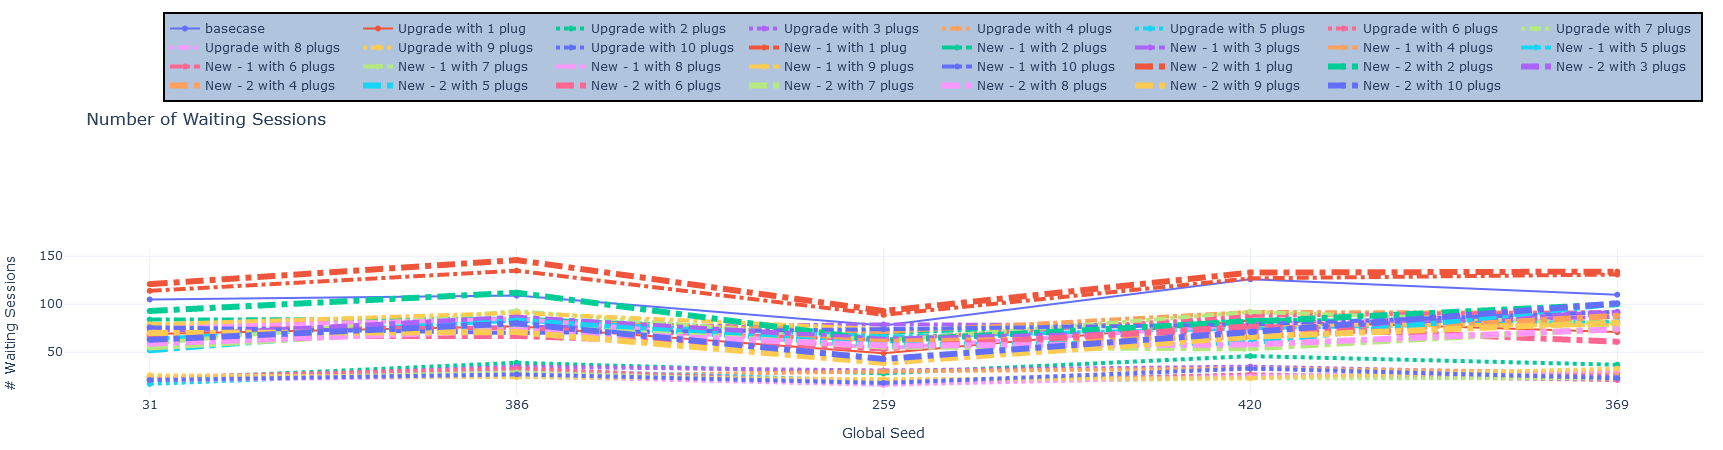

In [56]:
# waiting session count
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(671 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 675)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(676 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 680)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(681 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 685)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade with 2 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(686 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 690)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade with 3 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(691 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 695)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade with 4 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(696 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 700)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade with 5 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(701 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 705)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade with 6 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(706 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 710)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade with 7 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(711 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 715)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade with 8 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(716 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 720)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade with 9 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(721 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 725)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade with 10 plugs', line=dict(width=4, dash='dot')))

## New - 1
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(726 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 730)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 1 with 1 plug', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(731 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 735)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 1 with 2 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(736 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 740)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 1 with 3 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(741 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 745)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 1 with 4 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(746 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 750)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 1 with 5 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(751 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 755)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 1 with 6 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(756 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 760)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 1 with 7 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(761 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 765)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 1 with 8 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(766 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 770)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 1 with 9 plugs', line=dict(width=4, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(771 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 775)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 1 with 10 plugs', line=dict(width=4, dash='dashdot')))

## New - 2
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(776 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 780)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 2 with 1 plug', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(781 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 785)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 2 with 2 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(786 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 790)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 2 with 3 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(791 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 795)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 2 with 4 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(796 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 800)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 2 with 5 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(801 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 805)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 2 with 6 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(806 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 810)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 2 with 7 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(811 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 815)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 2 with 8 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(816 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 820)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 2 with 9 plugs', line=dict(width=6, dash='dashdot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(821 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 825)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New - 2 with 10 plugs', line=dict(width=6, dash='dashdot')))


fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of Waiting Sessions',
        showlegend = True, yaxis_title="# Waiting Sessions", 
                  xaxis_title="Global Seed", legend=dict(
    orientation="h",
    yanchor="bottom",
    y=2,
    xanchor="right",
    x=1,
    bgcolor="LightSteelBlue",
    bordercolor="Black",
    borderwidth=2
))
fig.show()

In [34]:
token = os.getenv("MAPBOX_ACCESS_TOKEN")
# analysis_ids = new_evses['analysis_id'].unique()

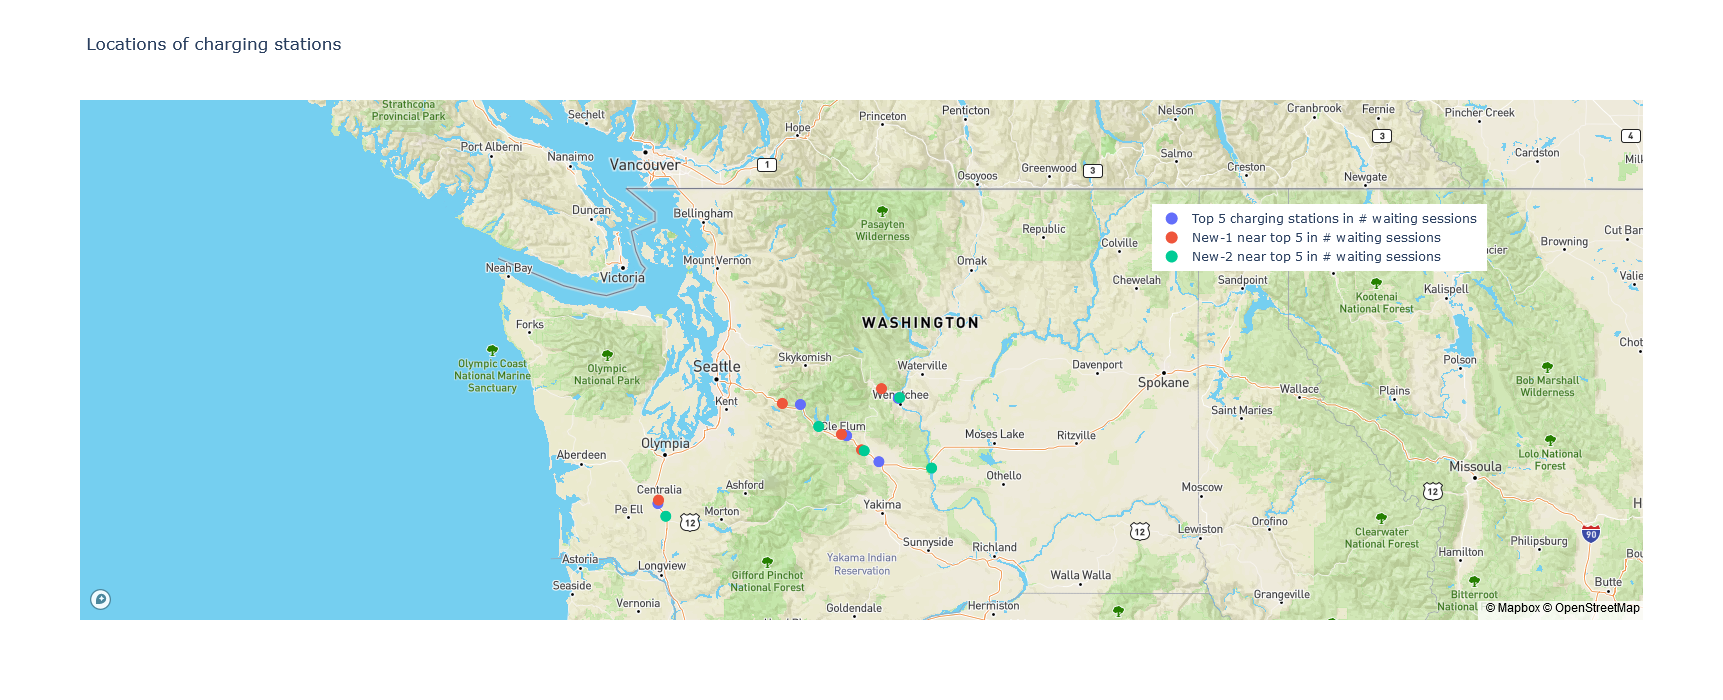

In [58]:
fig = go.Figure()
fig.add_trace(go.Scattermapbox(
        lat=be_ws['latitude'],
        lon=be_ws['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            opacity=1
        ),
        hoverinfo='none', 
    name='Top 5 charging stations in # waiting sessions'
    ))
fig.add_trace(go.Scattermapbox(
        lat=ne_ws[ne_ws['analysis_id'] == 520]['latitude'],
        lon=ne_ws[ne_ws['analysis_id'] == 520]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            opacity=1
        ),
        hoverinfo='none', 
    name='New-1 near top 5 in # waiting sessions'
    ))
fig.add_trace(go.Scattermapbox(
        lat=ne_ws[ne_ws['analysis_id'] == 526]['latitude'],
        lon=ne_ws[ne_ws['analysis_id'] == 526]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            opacity=1
        ),
        hoverinfo='none', 
    name='New-2 near top 5 in # waiting sessions'
    ))
fig.update_layout(
        title_text = 'Locations of charging stations',
        showlegend = True,
        mapbox_style="streets", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700, legend=dict(
    yanchor="top",
    y=0.8,
    xanchor="right",
    x=0.9
)
    )

fig.show()

In [ ]:
a_ids

____________
____________

Things to do the first time if the plotly plots not showing. Restart jupyter lab after. 

In [ ]:
#!jupyter labextension list

In [ ]:
#!jupyter labextension uninstall jupyterlab-plotly

In [ ]:
#!jupyter labextension uninstall plotlywidget

In [ ]:
#!export NODE_OPTIONS=--max-old-space-size=4096

In [ ]:
#!pip show plotly

In [ ]:
#!pip install jupyterlab "ipywidgets>=7.5"

In [ ]:
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [ ]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [ ]:
#!pip install "nbconvert<6"